#   LangGraph 활용 - 메시지 그래프 + 리듀서 구현

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true  # 모니터링 활성화할꺼냐


---

## **Reducer (리듀서)**

- **State Reducer**는 LangGraph의 **상태 관리 핵심 메커니즘**

- 각 노드의 출력을 **전체 그래프 상태에 통합**하는 방식을 정의

- **Reducer의 필요성**:

    - **상태 덮어쓰기 문제**: 기본적으로 각 노드의 반환값은 해당 상태 키의 이전 값을 덮어쓰는 방식으로 동작 (override)
    
    - **누적 업데이트 필요**: 특히 메시지 리스트와 같은 경우, 이전 상태에 새로운 값을 추가하고 싶을 때가 있음 

`(1) Reducer를 별도로 지정하지 않은 경우 `

- **기본 Reducer**는 이전 값을 **자동으로 덮어쓰는** 방식으로 작동
- Reducer 설정이 없는 경우 **자동으로 기본값**이 적용
- 이는 단순한 상태 업데이트에는 적합하나 **데이터 누적이 필요한 경우 부적절**
- 기본 Reducer는 **간단한 상태 관리**에 적합하지만 복잡한 데이터 처리에는 한계가 있음

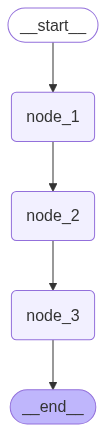

In [4]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 상태 정의 
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요.", "documents": None}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc2.pdf', 'doc4.pdf', 'doc5.pdf']


`(2) Reducer를 별도로 지정하는 경우 `

- **Annotated**를 통해 **사용자 정의 Reducer**를 지정할 수 있음 
- **operator.add**를 사용하면 리스트 형태의 데이터를 **누적 관리**할 수 있음 
- 여기서는 기존 리스트에 새로운 메시지를 추가하는 방식으로 작동

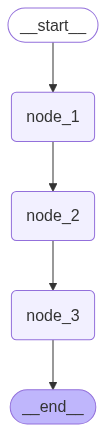

In [6]:
from operator import add
from typing import Annotated, TypedDict

class ReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], add] # 리듀서 작업

# Node 1: query 업데이트
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요.", "documents": []}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc2.pdf', 'doc4.pdf', 'doc5.pdf']


`(3) Custom Reducer 사용 `

- **Custom Reducer**는 **복잡한 상태 관리**가 필요할 때 사용됨 
- **중복 제거**나 **최대/최소값 유지**와 같은 특수한 로직을 구현할 수 있음 
- 비즈니스 요구사항에 맞는 **맞춤형 상태 관리**가 가능
- 상황에 따라 **조건부 병합**과 같은 고급 기능을 구현할 수 있음 

In [9]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하며 리스트 병합
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    return sorted(list(set(left + right)), reverse=True) #  정렬까지

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_documents]  # Custom Reducer 적용

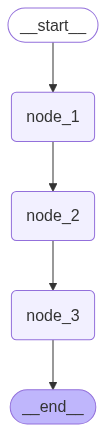

In [10]:
# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요.", "documents": []}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc5.pdf', 'doc4.pdf', 'doc3.pdf', 'doc2.pdf', 'doc1.pdf']


---

## **Message 사용**

- **LangGraph**는 **메시지 목록** 기반의 채팅 모델 인터페이스를 활용

- `HumanMessage`와 `AIMessage` 등 다양한 메시지 타입을 지원

- 그래프 상태에서 대화 기록은 **메시지 객체 리스트**로 저장되며, 이를 통해 효율적인 대화 관리를 가능

- **reducer 함수**를 통해 상태 업데이트 시 메시지 목록이 어떻게 갱신될지 정의할 수 있음 

`(1) operator.add` - 채팅히스토리 관리할때, 새로운 메세지 방식과 기존 메세지 방식 제공

- 메시지 목록에 새로운 메시지를 간단히 추가하는 기본적인 reducer 함수
    1. `messages` 키가 메시지 리스트를 저장
    2. `add` reducer가 새 메시지를 기존 리스트에 추가
    3. 모든 종류의 메시지(`HumanMessage`, `AIMessage` 등)가 허용됨

- 주의사항:
    - `operator.add`는 단순히 리스트를 연결
    - 중복 메시지도 추가됨
    - 메시지 삭제나 수정은 불가능

In [12]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from operator import add

# 상태 정의
class GraphState(TypedDict): # 메세지 목록 관리해 주는 상태
    messages: Annotated[list[AnyMessage], add] # 메세지 들로 이루어진 리스트들(메세지 계속 추가)

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]} # 이전대화 목록까지 참고해서 답변으로 이루어진 리스트

In [13]:
# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot) # 챗봇 노드 추가

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages']) #  AI 메세지 추가되어 표현
    print("-"*100)

[('user', '안녕하세요!')]
----------------------------------------------------------------------------------------------------
[('user', '안녕하세요!'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_79b79be41f', 'id': 'chatcmpl-BbzE8izlEbmzodH2n2ayRrKV9tpAk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--21959da1-69ec-43b6-bcc6-645a99c1e586-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
------------------------------------

`(2) add_messages` 

- 메시지 ID를 기반으로 기존 메시지를 업데이트하거나 새 메시지를 추가하는 고급 관리 기능을 제공
    - 새 메시지는 기존 목록에 추가
    - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)

- 기존 메시지의 중복 추가를 방지
- 메세지를 관리해주는 전용 리듀서(기존메세지 중복 방지)

In [14]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages # add_messages 이 메소드를 씀으로써 상태관리 정확하게 해줌

# add_messages 사용 상태 정의
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='1c8382d6-753a-425e-9bd2-cfb54c1cfccd')]
----------------------------------------------------------------------------------------------------
[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='1c8382d6-753a-425e-9bd2-cfb54c1cfccd'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BbzFPKxFD0avXtP0YphQ4KRlxp0yL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e65154c5-ec55-4dd5-9eb6-63924ef48d05-0', usage_metadata={'input_to

`(3) MessagesState`

- **`MessagesState`** 는 메시지 관리를 위해 미리 정의된 상태 타입

- 이 상태는 **`add_messages` reducer**를 기본으로 사용하여 메시지 업데이트를 자동으로 처리

- `AnyMessage` 객체 리스트를 포함하는 **단일 `messages` 키**로 구성되어 있어 구조가 단순함 

In [15]:
from langgraph.graph import MessagesState

# messages 키를 가진 상태 생성 (messages 키는 기본 제공)
class GraphState(MessagesState):  # MessagesState 상속
    ... 
    # 추가적인 필드 정의 가능
    # custom_field: str

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='14ecc591-5c33-4c59-b832-3ce23752e6c3')]
----------------------------------------------------------------------------------------------------
[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='14ecc591-5c33-4c59-b832-3ce23752e6c3'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_71b9d4b387', 'id': 'chatcmpl-Bc0iVCe8ieofJFm0ThNXrFYnzri6l', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c31ce4d4-8c69-4251-bab8-df08e1cc1f1b-0', usage_metadata={'input_to

`(4) MessagesState 커스텀 필드 추가`

- **MessagesState**를 상속받아 추가 필드를 포함하는 새로운 상태 타입을 정의할 수 있음 

- 기존 `messages` 키의 **`add_messages` reducer** 기능을 그대로 유지

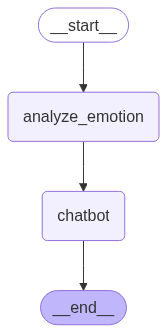

In [16]:
from typing import Optional
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI

# MessagesState를 상속하여 커스텀 필드 추가
class GraphState(MessagesState):
    # 사용자의 감정 상태를 추적하는 필드 추가
    # emotion: Optional[str] 
    emotion: [str]  # emotion은 (감정) 문자열로 가도됨

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 감정 분석을 위한 프롬프트 템플릿
EMOTION_PROMPT = """
사용자의 메시지를 분석하여 감정 상태를 파악해주세요.
가능한 감정 상태: 행복, 슬픔, 화남, 중립

사용자 메시지: {message}

감정 상태만 한 단어로 답변해주세요.
"""

# 감정 분석 노드
def analyze_emotion(state: GraphState) -> GraphState:
    # 가장 최근 사용자 메시지 가져오기
    last_message = state["messages"][-1].content # 가장 마지막에 추가된 메세지가 사용자 메세지임. 
    
    # 감정 분석 실행
    emotion_analysis = llm.invoke(EMOTION_PROMPT.format(message=last_message))
    
    # 상태 업데이트
    return {
        "emotion": emotion_analysis.content.strip() # 위의 프로프트를 이용후 사용자의 감정분석
    }

# 챗봇 응답 노드
def chatbot(state: GraphState) -> GraphState:
    # 현재 감정 상태를 고려한 시스템 메시지 생성
    system_message = f"""
    사용자의 현재 감정 상태는 {state['emotion']}입니다.
    이를 고려하여 공감적이고 적절한 응답을 해주세요.
    """
    
    # 기존 메시지에 시스템 메시지 추가
    messages = [{"role": "system", "content": system_message}] + state["messages"] # system 메세지 role 추가 후 상태로 부터 주고받은 챗팅 메세지 모두 전달
    
    # LLM 응답 생성
    response = llm.invoke(messages)
    
    return {"messages": [response]} # 메세지스의 필드에 리스트로 업데이트

# Workflow Graph 구성
builder = StateGraph(GraphState)

# 노드 추가
builder.add_node("analyze_emotion", analyze_emotion)
builder.add_node("chatbot", chatbot)

# 엣지 추가
builder.add_edge(START, "analyze_emotion")
builder.add_edge("analyze_emotion", "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# 초기 상태
initial_state = {
    "messages": [{"role": "user", "content": "오늘 정말 힘든 하루였어요..."}]
}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    if "emotion" in event:
        print(f"감정 상태: {event['emotion']}")
    if "messages" in event:
        print("메시지:")
        for msg in event["messages"]:
            print(f"{msg.type}: {msg.content}")
    print("-"*100)

메시지:
human: 오늘 정말 힘든 하루였어요...
----------------------------------------------------------------------------------------------------
감정 상태: 슬픔
메시지:
human: 오늘 정말 힘든 하루였어요...
----------------------------------------------------------------------------------------------------
감정 상태: 슬픔
메시지:
human: 오늘 정말 힘든 하루였어요...
ai: 정말 많이 힘드셨겠어요. 그런 날에는 마음이 무거워지고 지치기 마련인데, 이렇게 이야기해 주셔서 고마워요. 혹시 무엇이 가장 힘들었는지 나눠주실 수 있을까요? 함께 이야기하면서 조금이라도 마음이 편해졌으면 좋겠어요.
----------------------------------------------------------------------------------------------------


---
## **[실습]**

- 문제: 주어진 텍스트에 대해 검색-요약-팩트체크의 3단계 파이프라인을 구현하는 LangGraph 워크플로우를 작성하세요.

- 입력/출력:
  * 입력: 검색할 주제나 질문
  * 출력: 관련 정보 검색 결과, 요약본, 팩트체크 결과

- 제약사항:
  * LangGraph의 StateGraph를 사용하여 구현
  * 최소 3개의 노드(검색, 요약, 팩트체크) 구현
  * MessagesState를 상속한 커스텀 상태 클래스 사용
  * 각 단계의 신뢰도 점수 포함

In [ ]:
results

In [18]:
from typing import Optional, List, Dict, Any
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults

class ResearchState(MessagesState):
    search_results: Optional[List[Dict[str, Any]]]  # 검색 결과를 저장하는 필드
    summary: Optional[str]
    fact_check: Optional[Dict[str, Any]]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 검색 노드
def search_info(state: ResearchState) -> ResearchState:
    search_tool = TavilySearchResults(
        max_results=5,  # 반환할 결과의 수
        search_depth="advanced",  # 검색 깊이: basic 또는 advanced
        include_answer=True,  # 결과에 직접적인 답변 포함
        include_raw_content=True,  # 페이지의 원시 콘텐츠 포함
        include_images=True,  # 결과에 이미지 포함
    )

    # 사용자의 마지막 메시지에서 쿼리 추출
    query = state["messages"][-1].content
    
    # 검색 실행
    results = search_tool.invoke(query)
    
    return {
        "search_results": results  
    }

# 요약 노드
def generate_summary(state: ResearchState) -> ResearchState:
    if not state["search_results"]:
        return {"summary": "검색 결과가 없습니다."}
    
    summary_prompt = """
    다음 검색 결과들을 요약해주세요:
    {search_results}
    
    핵심 포인트 3-4개로 간단히 요약:
    """
    
    # 검색 결과를 문자열로 변환하여 프롬프트에 포함
    formatted_results = []
    for item in state["search_results"]:
        if "raw_content" in item:
            formatted_results.append(f"제목: {item.get('title', 'No title')}\n내용: {item['raw_content']}\n링크: {item.get('url', 'No URL')}\n")
        else:
            formatted_results.append(f"제목: {item.get('title', 'No title')}\n내용: {item.get('content', 'No content')}\n링크: {item.get('url', 'No URL')}\n")
    
    search_text = "\n\n".join(formatted_results)
    
    summary = llm.invoke(summary_prompt.format(
        search_results=search_text
    ))
    
    return {"summary": summary.content}

In [19]:
from pydantic import BaseModel, Field
from typing import Dict


class FactCheckResult(BaseModel):
    """팩트체크 결과를 위한 스키마"""
    confidence: str = Field(
        description="문장에 대한 팩트체크 신뢰도 점수 (0-1 사이의 값)"
    )

# 팩트체크 노드
def check_fact(state: ResearchState) -> ResearchState:
    """요약 내용에 대한 팩트체크를 수행하는 노드"""
    
    if not state["summary"]:
        return {"fact_check": {"scores": {}}}
    
    fact_check_prompt = """다음 요약 내용의 각 문장에 대해 신뢰도를 평가해주세요.

요약 내용:
{summary}

각 문장의 신뢰도를 0과 1 사이의 숫자로 평가하여 JSON 형식으로 반환해주세요.
신뢰도가 높을수록 1에 가깝고, 낮을수록 0에 가깝습니다.

예시 응답 형식:
{{
    "scores": {{
        "1": 0.9,  # 첫 번째 문장의 신뢰도
        "2": 0.7,  # 두 번째 문장의 신뢰도
        "3": 0.85  # 세 번째 문장의 신뢰도
    }}
}}

요약의 각 문장을 평가하여 위와 같은 형식으로 신뢰도 점수를 반환해주세요."""
    
    fact_checker = llm.with_structured_output(FactCheckResult)
    
    try:
        result = fact_checker.invoke(
            fact_check_prompt.format(summary=state["summary"])  # 
        )
        return {"fact_check": result.model_dump()}
        
    except Exception as e:
        print(f"팩트체크 중 오류 발생: {str(e)}")
        return {"fact_check": {"scores": {}}}

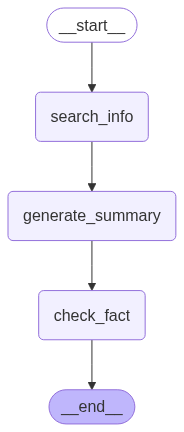

In [20]:
# 그래프 구성
builder = StateGraph(ResearchState)

builder.add_node("search_info", search_info)
builder.add_node("generate_summary", generate_summary)
builder.add_node("check_fact", check_fact)

builder.add_edge(START, "search_info")
builder.add_edge("search_info", "generate_summary")
builder.add_edge("generate_summary", "check_fact")
builder.add_edge("check_fact", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "인공지능의 환경적 영향은?"}]
})

print(f"검색 결과 수: {len(result['search_results'])}")
print("검색 결과:", result["search_results"])
print("-" * 100)
print(f"요약: {result['summary']}")
print(f"팩트체크 결과: {result['fact_check']}")

AttributeError: 'str' object has no attribute 'get'

---

## **병렬 처리**

- **분기(branching)** 기능을 통해 LangGraph에서 노드의 병렬 실행이 가능

- 병렬 처리는 **독립적인 작업**들을 동시에 실행함으로써 전체 처리 시간을 단축

- 다양한 데이터 소스에서 **정보 수집 및 처리**가 필요한 경우 병렬 실행이 특히 효과적

`(1) 표준 엣지를 사용한 분기 (Fan-out/Fan-in)`

- **Fan-out** 구조는 하나의 노드에서 여러 병렬 노드로 데이터를 분산시키는 방식을 구현

- **Fan-in** 구조는 병렬로 처리된 여러 노드의 결과를 단일 노드에서 취합하는 역할

- 가장 기본적이고 직관적인 병렬 처리 구조

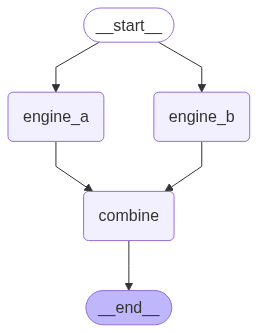

In [23]:
# 여러 검색 엔진에서 정보 가져오기

import operator
from typing import Annotated, Any, TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 정의: 검색 결과를 누적할 리스트를 포함
class SearchState(TypedDict):
    search_results: Annotated[list, operator.add]

# 각 검색 엔진에 대한 노드 정의
def search_engine_a(state: SearchState):
    print("Searching with Engine A...")
    return {"search_results": ["Result A1", "Result A2"]}

def search_engine_b(state: SearchState):
    print("Searching with Engine B...")
    return {"search_results": ["Result B1"]}

def combine_results(state: SearchState):
    print("Combining search results...")
    return {"search_results": ["Combined Result"]}

# 그래프 구성
search_builder = StateGraph(SearchState)
search_builder.add_node("engine_a", search_engine_a)
search_builder.add_node("engine_b", search_engine_b)
search_builder.add_node("combine", combine_results)

# 엣지 연결: START -> engine_a, engine_b (병렬 실행) -> combine -> END
search_builder.add_edge(START, "engine_a")
search_builder.add_edge(START, "engine_b")
search_builder.add_edge("engine_a", "combine")
search_builder.add_edge("engine_b", "combine")
search_builder.add_edge("combine", END)

# 그래프 컴파일
search_graph = search_builder.compile()

# 그래프 시각화
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [24]:
# 그래프 실행
search_graph.invoke({"search_results": []})

Searching with Engine A...
Searching with Engine B...
Combining search results...


{'search_results': ['Result A1', 'Result A2', 'Result B1', 'Combined Result']}

`(2) 조건부 엣지를 사용한 분기 (Conditional Branching)`

- **Fan-out** 구조는 하나의 노드에서 여러 병렬 노드로 데이터를 분산시키는 방식을 구현

- **Fan-in** 구조는 병렬로 처리된 여러 노드의 결과를 단일 노드에서 취합하는 역할

- 가장 기본적이고 직관적인 병렬 처리 구조

**구현 예시**

- 초기 그리팅 후 조건부로 서비스를 실행
- 선택된 서비스들을 병렬로 실행
- 모든 서비스 실행 후 최종 처리를 수행
- 전체 과정의 상태를 추적

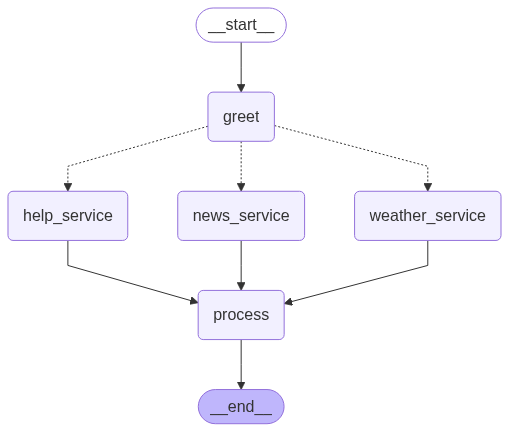

In [25]:
import operator
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 정의: aggregate 리스트와 라우팅을 위한 user_intent 필드 포함
class ChatState(TypedDict):
    messages: Annotated[list, operator.add]  # aggregate 대신 messages 사용
    user_intent: str  # 라우팅 조건

# 서비스 노드 정의
def greet_service(state: ChatState):
    print(f'Adding "greet" to {state["messages"]}')
    return {"messages": ["Hello!"]} 

def weather_service(state: ChatState):
    print(f'Adding "weather" to {state["messages"]}')
    return {"messages": ["The weather is sunny."]}

def news_service(state: ChatState):
    print(f'Adding "news" to {state["messages"]}')
    return {"messages": ["Here's the latest news."]}

def help_service(state: ChatState):
    print(f'Adding "help" to {state["messages"]}')
    return {"messages": ["How can I help you?"]}

def process_response(state: ChatState):
    print(f'Adding "process" to {state["messages"]}')
    return {"messages": ["Processing complete."]}

# 라우팅 함수: user_intent 값에 따라 서비스 노드 결정
def route_services(state: ChatState) -> Sequence[str]:
    if state["user_intent"] == "weather_news":
        # 날씨와 뉴스 서비스를 병렬 실행
        return ["weather_service", "news_service"]
    
    # 기본적으로 인사와 뉴스 서비스를 병렬 실행
    return ["help_service", "news_service"]

# 그래프 구성
chat_builder = StateGraph(ChatState)

# 노드 추가
chat_builder.add_node("greet", greet_service)
chat_builder.add_node("weather_service", weather_service)
chat_builder.add_node("news_service", news_service)
chat_builder.add_node("help_service", help_service)
chat_builder.add_node("process", process_response)

# 엣지 추가
chat_builder.add_edge(START, "greet")

# 중간 노드 정의
intermediates = ["weather_service", "news_service", "help_service"]

# greet 노드에서 조건부 엣지 추가
chat_builder.add_conditional_edges(
    "greet",
    route_services,
    intermediates,
)

# 중간 노드들을 process 노드에 연결
for node in intermediates:
    chat_builder.add_edge(node, "process")

chat_builder.add_edge("process", END)

# 그래프 컴파일
chat_graph = chat_builder.compile()

# 그래프 시각화
display(Image(chat_graph.get_graph().draw_mermaid_png()))

In [26]:
# "weather_news" 의도를 가지고 실행
chat_graph.invoke({"messages": [], "user_intent": "weather_news"})

Adding "greet" to []
Adding "news" to ['Hello!']
Adding "weather" to ['Hello!']
Adding "process" to ['Hello!', "Here's the latest news.", 'The weather is sunny.']


{'messages': ['Hello!',
  "Here's the latest news.",
  'The weather is sunny.',
  'Processing complete.'],
 'user_intent': 'weather_news'}

In [27]:
# 다른 의도를 가지고 실행
chat_graph.invoke({"messages": [], "user_intent": "news"})

Adding "greet" to []
Adding "help" to ['Hello!']
Adding "news" to ['Hello!']
Adding "process" to ['Hello!', 'How can I help you?', "Here's the latest news."]


{'messages': ['Hello!',
  'How can I help you?',
  "Here's the latest news.",
  'Processing complete.'],
 'user_intent': 'news'}

`(3) 다단계 분기 (Multi-step Parallel Paths)`

- **다단계 분기**는 각각의 병렬 경로에서 여러 단계의 독립적인 처리를 지원 

- 각 분기는 **서로 다른 데이터 처리 파이프라인**을 포함할 수 있어, 복잡한 워크플로우 구현이 가능

- 최종적으로 각 분기의 결과는 하나의 노드에서 **통합되어 처리**될 수 있음 

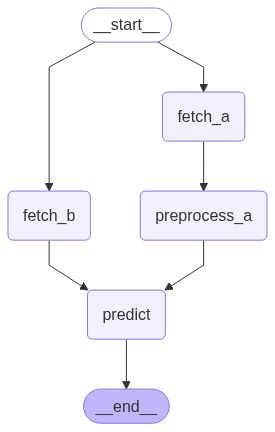

In [28]:
# 데이터 전처리와 모델 예측을 병렬로 수행하기

import operator
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END

class ModelState(TypedDict):
    data: Annotated[list, operator.add]

def fetch_data_a(state: ModelState):
    return {"data": ["Data A1"]}

def preprocess_data_a(state: ModelState):
    return {"data": ["Preprocessed A1"]}

def fetch_data_b(state: ModelState):
    return {"data": ["Data B1"]}

def make_prediction(state: ModelState):
    return {"data": ["Prediction from A and B"]}

model_builder = StateGraph(ModelState)
model_builder.add_node("fetch_a", fetch_data_a)
model_builder.add_node("preprocess_a", preprocess_data_a)
model_builder.add_node("fetch_b", fetch_data_b)
model_builder.add_node("predict", make_prediction)


# 다단계 스탭
model_builder.add_edge(START, "fetch_a")            # START -> fetch_a
model_builder.add_edge(START, "fetch_b")            # START -> fetch_b
model_builder.add_edge("fetch_a", "preprocess_a")   # fetch_a -> preprocess_a
model_builder.add_edge(["preprocess_a", "fetch_b"], "predict")  # preprocess_a -> fetch_b
model_builder.add_edge("predict", END)              # predict -> END

model_graph = model_builder.compile()

display(Image(model_graph.get_graph().draw_mermaid_png()))

In [29]:
# 그래프 실행
model_graph.invoke({"data": []})

{'data': ['Data A1', 'Data B1', 'Preprocessed A1', 'Prediction from A and B']}

`(4) 동적 엣지 생성 및 개별 상태 전달하기 (Map-Reduce 패턴)`
(제일 중요한 방법) - 웹url이 100개면 병렬로 처리하는 방식
- **기본 동작의 한계**

    - 기본적으로 LangGraph의 노드와 엣지는 미리 정의되며, 모든 노드는 동일한 공유 상태(shared state)를 사용함. 하지만 다음과 같은 경우에는 문제가 발생할 수 있음. 

    -  **동적 엣지:** 실행 시점에 따라 연결해야 할 노드의 수가 달라지는 경우 (예: 입력 데이터에 따라 다른 개수의 하위 작업을 생성해야 하는 경우)
    -  **개별 상태:** 각 노드가 독립적인 상태를 가지고 작업해야 하는 경우 (예: 각 하위 작업이 서로 다른 데이터를 처리해야 하는 경우)

- **Map-Reduce 패턴**

    1.  **Map:**  하나의 노드(mapper)가 여러 개의 객체(또는 작업)를 생성
    2.  **Reduce:** 다른 노드(reducer)가 mapper가 생성한 객체들을 처리하고 결과를 결합

-  **`Send` 객체**

    - LangGraph에서는 `Send` 객체를 사용하여 map 단계를 구현할 수 있음 
    - `Send` 객체는 조건부 엣지(`add_conditional_edges`)의 `condition_function`에서 반환될 수 있으며, 다음과 같은 두 가지 인수를 받아서 구현

        1.  **`node_name` (str):**  실행할 노드의 이름
        2.  **`state` (dict):** 해당 노드에 전달할 개별 상태

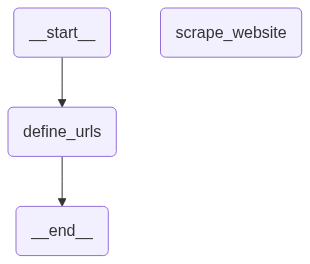

In [32]:
# 이 패턴의 장점은 참조할 url을 수집할때, 몇개가 되던간에 노드 별도 추가 할 필요없이, 동적으로 노드가 생성되기 때문에 유용

import operator
from typing import Annotated, List, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display

# 글로벌 상태 정의
class WebScrapingState(TypedDict):
    urls: List[str]  # 스크래핑할 URL 목록 (글로벌) # 수집할 url저장할 상태, 초기입력
    scraped_data: Annotated[List[dict], operator.add]  # 스크래핑된 데이터 (글로벌, 누적)       # 수집된 url추가 입력 

# 노드 정의
def define_urls(state: WebScrapingState):       # 쉽게 생각하자 WebScrapingState : 딕셔너리, 어차피 처음에 딕셔너리 클래스 사용했기 때문에
    """URL 목록을 정의합니다. (글로벌 상태 사용)"""
    print("Using provided URLs...")
    return {"urls": state["urls"]}  # 글로벌 상태(urls) 사용

def scrape_website(state: dict):  # 로컬 상태를 받음
    """각 웹사이트를 스크래핑합니다. (로컬 상태 사용)"""
    print(f"Scraping {state['url']}...")  # 로컬 상태(url) 사용
    # 실제 스크래핑 로직 (여기서는 시뮬레이션)
    return {"scraped_data": [f"Data from {state['url']}"]} # 글로벌 상태(scraped_data) 사용


############## 가장 중요한 부분
# 랭그래프의 Send API로 scrape_website 노드에 "url": url} 데이터 보낸다. 동적으로 병력ㄹ로 3개 실행 
# send api에 전달 후, scrape_website로 보낸 후, scraped_data 로 리턴..
def route_to_scraping(state: WebScrapingState):
    """스크래핑 노드로 라우팅합니다. (글로벌 상태 사용, 로컬 상태 생성)"""
    # 글로벌 상태(urls)를 사용하여 로컬 상태({"url": url})를 생성하고 Send로 전달
    return [Send("scrape_website", {"url": url}) for url in state["urls"]] 


# 그래프 구성
graph = StateGraph(WebScrapingState)  
graph.add_node("define_urls", define_urls)
graph.add_node("scrape_website", scrape_website)

graph.set_entry_point("define_urls")

graph.add_conditional_edges(
    "define_urls",
    route_to_scraping,
)

graph.add_edge("scrape_website", END)

# 그래프 컴파일
compiled_graph = graph.compile()

# 그래프 시각화
display(Image(compiled_graph.get_graph().draw_mermaid_png()))  # 머메이드 시각화 하는 부분이 문제...

In [33]:
# 그래프 실행 (외부에서 URL 목록 입력)
initial_state = {"urls": ["https://example.com", "https://example.net", "https://example.org"]}
result = compiled_graph.invoke(initial_state)

Using provided URLs...
Scraping https://example.com...
Scraping https://example.net...
Scraping https://example.org...


```mermaid
graph LR
    define_urls[define_urls]
    scrape_website[scrape_website]
    _start((START)) --> define_urls
    define_urls --"Send(scrape_website)"--> scrape_website
    scrape_website --> _end((END))

```

In [34]:
pprint(result)

{'scraped_data': ['Data from https://example.com',
                  'Data from https://example.net',
                  'Data from https://example.org'],
 'urls': ['https://example.com', 'https://example.net', 'https://example.org']}


---
## **[실습]**

- LangGraph의 `Send` API를 사용하여 여러 단계를 거치는 리서치 어시스턴트를 구축합니다. 사용자가 질문을 하면, 어시스턴트는 다음 단계를 수행합니다.

    1.  **검색 (Search):** DuckDuckGo 검색을 통해 관련 정보를 찾습니다.
    2.  **요약 (Summary):** 검색 결과를 요약합니다.
    3. **팩트체크 (병렬처리):** 요약된 정보의 각 문장에 대해 신뢰도를 평가합니다. (Send API 사용)


`(1) 기본 설정 및 상태 정의`

In [ ]:
from typing import Annotated, List, TypedDict, Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
import operator
from IPython.display import Image, display

# 팩트 체크 결과를 위한 Pydantic 모델
class FactCheckResult(BaseModel):
    sentence: str
    score: float

# 전체 상태 정의 (글로벌 상태)
class OverallState(TypedDict):
    query: str  # 검색 쿼리
    search_results: Optional[List[Dict[str, Any]]] 
    summary: Optional[str]  # 요약문
    fact_check: Annotated[List[FactCheckResult], operator.add]  # 팩트체크 결과 (누적)

# 로컬 상태 (단일 문장 팩트체크용)
class SentenceState(TypedDict):
    sentence: str  # 팩트체크할 문장

`(2) 검색 노드 (Search Node)`

- Tavily 검색 도구를 사용하여 사용자 쿼리에 대한 검색을 수행
- `fact_check`는 빈 리스트로 초기화

In [ ]:
def search_info(state: OverallState) -> OverallState:
    search_tool = TavilySearchResults(
        max_results=5,  # 반환할 결과의 수
        search_depth="advanced",  # 검색 깊이: basic 또는 advanced
        include_answer=True,  # 결과에 직접적인 답변 포함
        include_raw_content=True,  # 페이지의 원시 콘텐츠 포함
        include_images=True,  # 결과에 이미지 포함
    )
    
    # 사용자의 쿼리 추출
    query = state["query"]

    # 검색 실행
    results = search_tool.invoke({"query": query})

    return {
        "search_results": results
    }

`(3) 요약 노드 (Summary Node)`

*   검색 결과가 없으면 "검색 결과가 없습니다."를 반환합니다.
*   LLM을 사용하여 검색 결과를 3-4개의 핵심 포인트로 요약합니다.

In [ ]:
def generate_summary(state: OverallState) -> OverallState:
    if not state["search_results"]:
        return {"summary": "검색 결과가 없습니다."}

    summary_prompt = """
    다음 검색 결과들을 요약해주세요:
    {search_results}

    핵심 포인트 3-4개로 간단히 요약:
    """

    # 검색 결과를 문자열로 변환하여 프롬프트에 포함
    formatted_results = []
    for item in state["search_results"]:
        if "raw_content" in item:
            formatted_results.append(f"제목: {item.get('title', 'No title')}\n내용: {item['raw_content']}\n링크: {item.get('url', 'No URL')}\n")
        else:
            formatted_results.append(f"제목: {item.get('title', 'No title')}\n내용: {item.get('content', 'No content')}\n링크: {item.get('url', 'No URL')}\n")
    search_text = "\n\n".join(formatted_results)
    summary_prompt = summary_prompt.format(search_results=search_text)

    summary = llm.invoke(summary_prompt)

    return {"summary": summary.content}

`(4)  팩트 체크 노드 (Fact-Check Node)`

-`Send` API를 사용하여 요약된 문장들을 병렬로 팩트 체크하는 노드를 정의

-  **fact_check_sentences 노드**: 
    - 요약이 없으면 빈 결과를 반환. 
    - 요약된 텍스트를 문장 단위로 분리하고, 각 문장에 대해 `Send("fact_check_sentence", {"sentence": s})`를 호출하여 **fact_check_sentence 노드**로 작업을 보냄
    - `Send`는 각 문장에 대한 별도의 실행 경로를 생성하여 병렬 처리


In [ ]:
from langgraph.types import Send

def fact_check_sentences(state: OverallState):
    if not state["summary"]:
        return {"fact_check": []}

    # 요약된 문장들을 분리 (간단하게 개항문자로 분리)
    sentences = state["summary"].split("\n\n")
    sentences = [s.strip() for s in sentences if s.strip()]  # 빈 문자열 제거

    print(f"Fact-checking {len(sentences)} sentences...")

    # 각 문장에 대해 팩트 체크 작업을 생성 (Send 사용)
    return [
        Send("fact_check_sentence", {"sentence": s}) for s in sentences
    ]

- **fact_check_single_sentence 함수** : 

    - **fact_check_sentences 노드**가 `Send` 한 것을 받아서 처리
    - 전달 받은 단일 문장에 대한 팩트 체크를 수행
    - LLM을 호출하여 신뢰도 점수를 얻고, `FactCheckResult` 형태로 결과를 반환


In [ ]:
def fact_check_single_sentence(state: SentenceState) -> OverallState:
    """개별 문장에 대한 팩트체크 수행"""
    sentence = state["sentence"]
    print(f"Fact-checking sentence: {sentence}")

    prompt = f"""
    다음 문장의 사실 여부를 평가하고 신뢰도 점수를 0과 1 사이로 제공해주세요:
    문장: {sentence}
    신뢰도 점수:
    """
    response = llm.invoke(prompt)

    # 팩트체크 결과 생성
    print(f"Fact-check result: {response.content}")
    
    try:
        score = float(response.content)
        score = max(0.0, min(1.0, score))  # 0과 1 사이로 제한
    except ValueError:
        score = 0.5  # 기본값
    
    return {
        "fact_check": [FactCheckResult(sentence=sentence, score=score)]
    } #type: ignore

`(5) 그래프 구성`

- **add_edge**: 노드 간의 일반적인 흐름을 정의 (검색 -> 요약)

- **add_conditional_edges**:  `START` 노드에서 사용자 쿼리가 있으면 `fact_check_sentences`로, 그렇지 않으면 `END`로 분기

- `builder.add_edge("fact_check_sentence", END)` : 팩트 체크 결과를 반환하는 노드를 `END`에 연결.


In [ ]:
# 그래프 구성
builder = StateGraph(OverallState)

# 노드 추가
builder.add_node("search", search_info)
builder.add_node("generate_summary", generate_summary)
builder.add_node("fact_check_sentence", fact_check_single_sentence)

# 엣지 추가
builder.add_edge(START, "search")
builder.add_edge("search", "generate_summary")
builder.add_conditional_edges(
    "generate_summary",
    fact_check_sentences,
    ["fact_check_sentence"]  
)

builder.add_edge("fact_check_sentence", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(6) 그래프 실행`

In [ ]:
# 사용자 질문
inputs = {"query": "기후 변화의 주요 원인은 무엇인가요?"}

# 그래프 실행
result = graph.invoke(inputs)

In [ ]:
pprint(result)